# Exploring the NHDPlus Seamless CONUS gdb
## Making tools to access individual features quickly

In [3]:
import fiona
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import shape

import sys; sys.path.append('..')
from fcast import StreamSegmentNHD

### Set the gdb path and the layer name
gdb source: http://www.horizon-systems.com/NHDPlus/V2NationalData.php

download link: http://www.horizon-systems.com/NHDPlusData/NHDPlusV21/Data/NationalData/NHDPlusV21_NationalData_Seamless_Geodatabase_Lower48_07.7z

documentation: http://www.horizon-systems.com/NHDPlusData/NHDPlusV21/Data/NationalData/0Release_Notes_NationalData_Seamless_GeoDatabase.pdf

In [4]:
gdb = r'data\NHDPlusV21\NHDPlusV21_National_Seamless_Flattened_Lower48.gdb'
lyr = 'NHDFlowline_Network'

### Open the gdb, layer

In [5]:
src = fiona.open(gdb, layer=lyr)

In [6]:
src.meta

{'driver': 'OpenFileGDB',
 'schema': {'properties': OrderedDict([('COMID', 'int'),
               ('FDATE', 'datetime'),
               ('RESOLUTION', 'str:7'),
               ('GNIS_ID', 'str:10'),
               ('GNIS_NAME', 'str:65'),
               ('LENGTHKM', 'float'),
               ('REACHCODE', 'str:14'),
               ('FLOWDIR', 'str:15'),
               ('WBAREACOMI', 'int'),
               ('FTYPE', 'str:24'),
               ('FCODE', 'int'),
               ('Shape_Length', 'float'),
               ('StreamLeve', 'float'),
               ('StreamOrde', 'float'),
               ('StreamCalc', 'float'),
               ('FromNode', 'float'),
               ('ToNode', 'float'),
               ('Hydroseq', 'float'),
               ('LevelPathI', 'float'),
               ('Pathlength', 'float'),
               ('TerminalPa', 'float'),
               ('ArbolateSu', 'float'),
               ('Divergence', 'float'),
               ('StartFlag', 'float'),
               ('Terminal

### Make a dict that allow for easy/fast indexing of our layer of interest

In [4]:
# comidDict = {src[f]['properties']['COMID']: f for f in src.keys()}

### Write it to a json

In [5]:
# with open('data/comidDict_NHDPlusV21.json', 'w') as fp:
#     json.dump(comidDict, fp, indent=2)

# END

---

#### dev work below

In [6]:
with open('data/NHDPlusV21/comidDict_NHDPlusV21.json') as f:
    comidDict = json.loads(f.read())

In [7]:
node_lyr = 'PlusFlow'
node_src = fiona.open(gdb, layer=node_lyr)

In [8]:
comid = 4512772 # some small segment on the Potomac near DC

In [9]:
# import importlib
# import fcast
# importlib.reload(fcast)
# import sys; sys.path.append('..')
# from fcast import StreamSegmentNHD

In [10]:
test = StreamSegmentNHD(comid, comidDict, src, warning=False)

In [11]:
test.from_node_id

200011819.0

In [12]:
test.to_node_id

200011746.0

In [13]:
node_src.meta['schema']['properties']

OrderedDict([('FROMCOMID', 'int'),
             ('FROMHYDSEQ', 'float'),
             ('FROMLVLPAT', 'float'),
             ('TOCOMID', 'int'),
             ('TOHYDSEQ', 'float'),
             ('TOLVLPAT', 'float'),
             ('NODENUMBER', 'float'),
             ('DELTALEVEL', 'int'),
             ('DIRECTION', 'int'),
             ('GAPDISTKM', 'float'),
             ('HasGeo', 'str:1'),
             ('TotDASqKM', 'float'),
             ('DivDASqKM', 'float')])

## Make a dict to easily access the PlusFlow layer

In [14]:
node_id_dict = {node_src[f]['properties']['NODENUMBER']: f for f in node_src.keys()}

## Pull the to/from comid based on matching node numbers

In [15]:
x = node_src[node_id_dict[test.from_node_id]]['properties']
assert x['TOCOMID'] == comid, "For some reason this Node Number is wrong"
fromcomid = x['FROMCOMID']

In [16]:
fromcseg = StreamSegmentNHD(fromcomid, comidDict, src, warning=False)

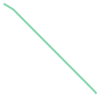

In [17]:
fromcseg.geometry

## Determine which end point is upstream and which is downstream

In [18]:
endpt1 = Point(list(list(fromcseg.geometry)[0].coords)[0])
endpt2 = Point(list(list(fromcseg.geometry)[0].coords)[-1])

In [19]:
endpt1.distance(test.geometry) # downstream

0.005169302509850152

In [20]:
endpt2.distance(test.geometry) # upstream

0.0

# Plot to visibly make sure they are next to each other

In [21]:
gdf = gpd.GeoDataFrame({comid: test.geometry, fromcomid: fromcseg.geometry}).T.reset_index().rename(columns={'index':'comid', 0:'geometry'}).set_geometry('geometry')
gdf

,comid,geometry
0,4512772,"LINESTRING Z (-77.13370 38.95432 0.00000, -77...."
1,4512770,"LINESTRING Z (-77.13741 38.95793 0.00000, -77...."


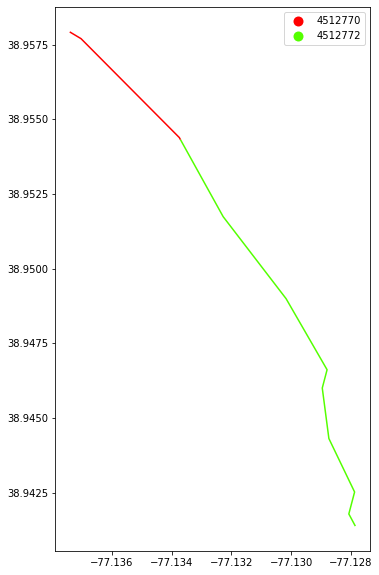

In [22]:
gdf.plot(figsize=(10,10), categorical=True, column='comid', legend=True, cmap='prism')

# Using the above, the upstream and downstream point can be determined, as well as the upstream and downstream comids

## Try to set up 'from_comid' and 'to_comid' attributes for the spatial index file

In [49]:
# comid : from node number
from_to_cid = {}
# comid : to node number
# tonode = {}

for cid, idx in comidDict.items():

    nhd_props = src[idx]['properties']
    
    fnode = nhd_props['FromNode']
    try:
        fnode_props = node_src[node_id_dict[fnode]]['properties']
        fromcomid = fnode_props['FROMCOMID']
    except KeyError as e:
        print(f'Error: {e}\n at node: {fnode}, comid: {cid}\n\n')
        fromcomid = 'HEADWATERS/COASTAL'
    
    tnode = nhd_props['ToNode']
    try: 
        tnode_props = node_src[node_id_dict[tnode]]['properties']
        tocomid = tnode_props['TOCOMID']
    except KeyError as e:
        print(f'Error: {e}\n at node: {tnode}, comid: {cid}\n\n')
        tocomid = 'HEADWATERS/COASTAL'
    
    from_to_cid[cid] = {'from_comid': fromcomid, 'to_comid': tocomid}

Error: 200111281.0
 at node: 200111281.0, comid: 8411203


Error: 200111272.0
 at node: 200111272.0, comid: 8411067


Error: 200111280.0
 at node: 200111280.0, comid: 8411201


Error: 200111279.0
 at node: 200111279.0, comid: 8411167


Error: 200111278.0
 at node: 200111278.0, comid: 8411157


Error: 200111276.0
 at node: 200111276.0, comid: 8411097


Error: 200111275.0
 at node: 200111275.0, comid: 8411093


Error: 200111273.0
 at node: 200111273.0, comid: 8411071


Error: 200111274.0
 at node: 200111274.0, comid: 8411081


Error: 200111271.0
 at node: 200111271.0, comid: 8411059


Error: 200111270.0
 at node: 200111270.0, comid: 8411057


Error: 200111267.0
 at node: 200111267.0, comid: 8411037


Error: 200111268.0
 at node: 200111268.0, comid: 8411039


Error: 200111269.0
 at node: 200111269.0, comid: 8411049


Error: 200111308.0
 at node: 200111308.0, comid: 8413047


Error: 200111307.0
 at node: 200111307.0, comid: 8413045


Error: 200111305.0
 at node: 200111305.0, comid: 8413037

### Why are there zeros?

In [66]:
zeros_comids = []
for k, v in from_to_cid.items():
    if v['from_comid'] == 0 or v['to_comid'] == 0:
        zeros_comids.append(k)

In [67]:
len(zeros_comids)

955351

In [68]:
from_to_cid[zeros_comids[100000]]

{'from_comid': 0, 'to_comid': 1051685}

### Why are there so few coastal/headwaters comids?

In [69]:
coast_head_comids = []
for k, v in from_to_cid.items():
    if v['from_comid'] == 'HEADWATERS/COASTAL' or v['to_comid'] == 'HEADWATERS/COASTAL':
        coast_head_comids.append(k)

In [70]:
len(coast_head_comids)

23

In [71]:
from_to_cid[coast_head_comids[15]]

{'from_comid': 'HEADWATERS/COASTAL', 'to_comid': 8413347}

## Get the line wkt geometry for the spatial index file

In [7]:
df = pd.read_csv('data/nwm-v1.2-channel_spatial_index_w_attrs.csv', index_col='feature_id')
df['ST'] = df['ST'].astype(str)
df['CNTY'] = df['CNTY'].astype(str)

c:\users\abrazeau\appdata\local\continuum\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\abrazeau\appdata\local\continuum\miniconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
df.head()

,latitude,longitude,ST,CNTY,pt_wkt
feature_id,,,,,
101,31.086876,-94.640541,48,48373,POINT (-94.6405410766601563 31.0868759155273438)
179,46.022163,-67.986412,23,23003,POINT (-67.9864120483398438 46.0221633911132813)
181,46.016491,-67.998726,23,23003,POINT (-67.9987258911132813 46.0164909362792969)
183,46.020847,-67.998833,23,23003,POINT (-67.9988327026367188 46.0208473205566406)
185,46.019714,-67.998619,23,23003,POINT (-67.9986190795898438 46.0197143554687500)


In [11]:
# df['line_wkt'] = df.feature_id.apply(lambda x: StreamSegmentNHD(x, comidDict, src, warning=False).geometry.to_wkt())

In [28]:
results = {src[f]['properties']['COMID']: shape(src[f]['geometry']).wkt for f in src.keys()}

In [29]:
output_dataframe = pd.DataFrame.from_dict([results]).T

In [34]:
output_dataframe.index.name = 'feature_id'
output_dataframe.rename(columns={0:'line_wkt'}, inplace=True)

In [36]:
output_dataframe.to_csv('data/comid_line_wkt.csv')

In [37]:
with_line = df.join(output_dataframe)
with_line.head()

,latitude,longitude,ST,CNTY,pt_wkt,line_wkt
feature_id,,,,,,
101,31.086876,-94.640541,48,48373,POINT (-94.6405410766601563 31.0868759155273438),MULTILINESTRING Z ((-94.64844683019334 31.0991...
179,46.022163,-67.986412,23,23003,POINT (-67.9864120483398438 46.0221633911132813),MULTILINESTRING Z ((-67.98139140491924 46.0332...
181,46.016491,-67.998726,23,23003,POINT (-67.9987258911132813 46.0164909362792969),MULTILINESTRING Z ((-67.99783367156044 46.0183...
183,46.020847,-67.998833,23,23003,POINT (-67.9988327026367188 46.0208473205566406),MULTILINESTRING Z ((-67.99946440489123 46.0210...
185,46.019714,-67.998619,23,23003,POINT (-67.9986190795898438 46.0197143554687500),MULTILINESTRING Z ((-67.99829800489294 46.0204...


In [39]:
import xarray as xr

In [40]:
ds = xr.Dataset.from_dataframe(with_line)

In [41]:
meta_ds = xr.open_dataset('data/nwm-v1.2-channel_spatial_index.nc')

In [45]:
ds.attrs = meta_ds.attrs

In [46]:
ds.to_netcdf('data/nwm-v1.2-channel_spatial_index_w_attrs.nc')

In [47]:
with_line.to_csv('data/nwm-v1.2-channel_spatial_index_w_attrs.csv')